# GSE233812

***此子系列是 SuperSeries 的一部分：GSE233815	急性脑缺血小鼠模型中神经胶质细胞反应的时空转录组图***

1. 标题: [急性脑缺血小鼠模型中神经胶质细胞反应的时空转录组图 [scRNA-Seq]](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE233812)
2. 种属: mmu
3. 实验类型: 通过高通量测序进行表达谱分析
4. 总结: 我们对雄性小鼠大脑进行了空间和单细胞转录组学，以绘制出受伤后第一周控制缺血性中风反应的分子和细胞过程。专注于神经胶质细胞，我们记录了它们的激活、神经胶质瘢痕的形成以及细胞间通讯模式的显着变化。有趣的是，我们鉴定了各种活化的少突胶质细胞群，这些细胞群虽然在抗炎特性上相似，但在免疫原性和代谢特性上有所不同。这挑战了长期以来认为少突胶质细胞在神经病理学中起被动作用的信念。总而言之，我们为目前对神经胶质细胞在中风病理生物学中的作用的理解做出了重大贡献，全面绘制了它们的急性反应和在神经胶质瘢痕形成中的作用。
5. 整体设计: 为了调查缺血性脑损伤，使用了永久性大脑中动脉闭塞的小鼠模型。筛选的时间点包括对照组、受伤后第 1 天、第 3 天和第 7 天。对于每个时间点，收集三个前脑半球 （前囟从 ~ +3 到 -4 mm），合并，FACS 分选出`Plp1+`的细胞 并使用 scRNA-Seq 方案进行处理。
6. 提供者: Zucha D， Abaffy P， Kirdajova D， Valihrach L， Jirak D， Kubista M， Anderova M
7. 引用文献: [Gao R, Bai S, Henderson YC, Lin Y, Schalck A, Yan Y, et al. Delineating copy number and clonal substructure in human tumors from single-cell transcriptomes. Nat Biotechnol. 2021;39(5):599–608. PMID：39499634](https://pubmed.ncbi.nlm.nih.gov/39499634)
8. 联系人姓名: Lukas Valihrach  卢卡斯·瓦利赫拉赫
9. 组织名称: Institute of Biotechnology, Czech Academy of Science 捷克科学院生物技术研究所
10. 实验室: Laboratory of Gene Expression 基因表达实验室
11. 实验平台: GPL24247 Illumina NovaSeq 6000(mmu)
12. 原始数据: [PRJNA978034](https://www.ncbi.nlm.nih.gov/Traces/study/?acc=PRJNA978034)

|Sample ID|实验分组|分组代号|
|---------|-------|------|
|GSM7437213|sham|sham|
|GSM7437214|pMCAO 第 1 天|D1|
|GSM7437215|pMCAO 第 3 天|D3|
|GSM7437226|pMCAO 第 7 天|D7|


## 数据读取

In [7]:
%reset -f
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import yaml
import os

print(os.getcwd())
sc.settings.verbosity = 3
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
    
targets = pd.DataFrame({
    "id": ["GSM7437213", "GSM7437214", "GSM7437215", "GSM7437226"],
    "species": ["wt", "wt", "wt", "wt"],
    "condition": ["sham", "D1", "D3", "D7"],
    "prefix": ["GSM7437213_sc-sham_", "GSM7437214_sc-D1_", "GSM7437215_sc-D3_", "GSM7437216_sc-D7_"],
})
targets.to_csv("data/targets.csv", index=None)
targets

/Volumes/MacPassport/project/bioinfo/GSE233815


,id,species,condition,prefix
0,GSM7437213,wt,sham,GSM7437213_sc-sham_
1,GSM7437214,wt,D1,GSM7437214_sc-D1_
2,GSM7437215,wt,D3,GSM7437215_sc-D3_
3,GSM7437226,wt,D7,GSM7437216_sc-D7_


如果 feature.txt.gz 没有包含三列就会报KeyError: 2 or 1, 理论上第一列是ensembl id，第二列是gene symbol，第三列是Gene Expression

但是实际上只要满足 总共三列+第2列全部是基因名即可

In [8]:
adatas = {}

for _,row in targets.iterrows():
    sample_adata = sc.read_10x_mtx(
        path="data/GSE233812_RAW/",
        var_names="gene_symbols",
        make_unique=True,
        prefix=row["prefix"]
    )
    sample_adata.obs["condition"] = row["condition"] # 给每个细胞加上样本标签
    adatas[row["id"]] = sample_adata

# 合并所有样本
adata_raw = ad.concat(adatas=adatas, label="sample")
adata_raw.raw = adata_raw.copy()
adata_raw.write(f"data/{config['project_code']}_sc_raw.h5ad")
adata_raw

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 27179520 × 46985
    obs: 'condition', 'sample'

## 过滤低质量细胞
细胞质控通常对以下三个质控协变量进行：

1. **测序深度**:每个barcode下的计数数量, 即对每个barcode的所有gene的counts求和
2. **测序覆盖度**:每个barcode下的基因数量, 对所有counts大于0的gene计数
3. **内参基因**:每个barcode下线粒体基因比例, 对所有内参基因的表达量求平均值

线粒体计数被注释为前缀`MT-`，对于鼠标数据集，前缀通常是小写，因此`mt-`。

In [9]:
%reset -f
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import yaml
import os
os.getcwd()
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
sc.settings.verbosity = 3

adata = ad.read_h5ad(f"data/{config['project_code']}_sc_raw.h5ad")
print(adata)
targets = pd.read_csv("data/targets.csv")

# 线粒体基因(人的用MT)
adata.var.loc[:,"mt"] = adata.var_names.str.contains("mt-")
# 核糖体基因
adata.var.loc[:,"ribo"] = adata.var_names.str.contains("RP[S|L]{1}")
# 血红蛋白基因(Hbp1基因是HMG盒转录因子1 (HMG-box transcription factor 1,HBP1)，是转录因子，和红细胞无关)
adata.var.loc[:,"hb"] = adata.var_names.str.contains("^H[B|b][^Pp]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

adata.obs[['total_counts','n_genes_by_counts','pct_counts_mt','pct_counts_ribo','pct_counts_hb']]

/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 27179520 × 46985
    obs: 'condition', 'sample'


,total_counts,n_genes_by_counts,pct_counts_mt,pct_counts_ribo,pct_counts_hb
AAACCCAAGAAACACT,0.0,0,NaN,NaN,NaN
AAACCCAAGAAACCAT,0.0,0,NaN,NaN,NaN
AAACCCAAGAAACCCA,0.0,0,NaN,NaN,NaN
AAACCCAAGAAACCCG,0.0,0,NaN,NaN,NaN
AAACCCAAGAAACCTG,0.0,0,NaN,NaN,NaN
...,...,...,...,...,...
TTTGTTGTCTTTGCTA,0.0,0,NaN,NaN,NaN
TTTGTTGTCTTTGCTG,0.0,0,NaN,NaN,NaN
TTTGTTGTCTTTGGAG,0.0,0,NaN,NaN,NaN
TTTGTTGTCTTTGGCT,0.0,0,NaN,NaN,NaN


| QC项                 | 描述                         |
| ------------------- | -------------------------- |
| `pct_counts_mt`     | 线粒体转录本比例（高代表细胞可能正在死亡）      |
| `total_counts`      | 每个细胞的总 UMI 数量（低说明测序浅或双重分离） |
| `n_genes_by_counts` | 检测到的基因数量（太少可能是空泡）          |
| `pct_counts_hb`     | 血红蛋白表达比例（常用于血液样本过滤）        |


zucha这个GSE数据集给的数据是下游的raw数据，标准需要定严格一些。文中说通过质检的细胞核数大约有7900-8000个，

In [14]:
thres={'mito_perc': 15, 'nUMIs': 1000, 'detected_genes': 250, 'hb_perc': 50}

# 线粒体基因含量占比
adata.obs['passing_mt'] = adata.obs['pct_counts_mt'] < thres['mito_perc']
# 每个细胞测得的总counts数
adata.obs['passing_nUMIs'] = adata.obs['total_counts'] > thres['nUMIs']
# 监测到的基因数量
adata.obs['passing_ngenes'] = adata.obs['n_genes_by_counts'] > thres['detected_genes']
# 血红素基因占比
adata.obs['passing_hb'] = adata.obs['pct_counts_hb'] < thres['hb_perc']

print(f"Lower threshold, total counts: {thres["nUMIs"]}; \
    filtered-out-cells: {adata.n_obs-np.sum(adata.obs["passing_nUMIs"])}")
print(f'Lower threshold, n genes: {thres["detected_genes"]};\
    filtered-out-cells: {adata.n_obs-np.sum(adata.obs["passing_ngenes"])}')
print(f'Lower threshold, mito %: {thres["mito_perc"]};\
    filtered-out-cells: {adata.n_obs-np.sum(adata.obs["passing_mt"])}')
print(f'Lower threshold, mito %: {thres["hb_perc"]};\
    filtered-out-cells: {adata.n_obs-np.sum(adata.obs["passing_hb"])}')

QC_test = (adata.obs['passing_mt']) & (adata.obs['passing_nUMIs']) & (adata.obs['passing_ngenes']) & (adata.obs['passing_hb'])
removed = QC_test.loc[lambda x : x == False]
print(f'Total cell filtered out with this last  QC (and its chosen options): {adata.n_obs-np.sum(QC_test)}')
n0 = adata.n_obs
adata = adata[QC_test, :].copy()
    
# Store cleaned adata
print(f'Cells retained after Lower threshold filtering: {adata.n_obs},\
{n0-adata.n_obs} removed.')

Lower threshold, total counts: 1000;     filtered-out-cells: 415
Lower threshold, n genes: 250;    filtered-out-cells: 0
Lower threshold, mito %: 15;    filtered-out-cells: 0
Lower threshold, mito %: 50;    filtered-out-cells: 0
Total cell filtered out with this last  QC (and its chosen options): 415
Cells retained after Lower threshold filtering: 6021,415 removed.


/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


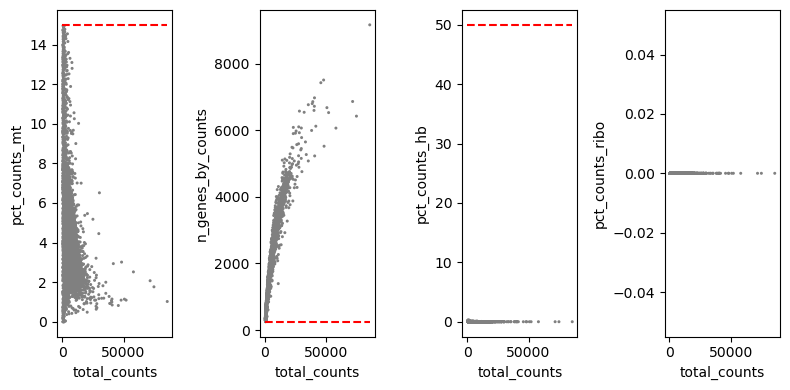

In [11]:
import matplotlib.pyplot as plt
# 阈值
mito_filter = thres['mito_perc']
n_counts_filter = thres['detected_genes']
hb_filter = thres['hb_perc']
# 设置图片布局
fig, axs = plt.subplots(ncols = 4, figsize = (8,4))
# 绘制散点图
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',ax = axs[0], show=False)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',ax = axs[1], show = False)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_hb',ax = axs[2], show=False)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_ribo',ax = axs[3], show=False)
# 绘制阈值标志线
axs[0].hlines(y = mito_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
axs[1].hlines(y = n_counts_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
axs[2].hlines(y = hb_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
# 紧致边界
fig.tight_layout()
plt.show()

In [12]:
n0 = adata.n_obs
# 清理低测序深度的barcode
# inplace = True:执行后覆盖原变量
sc.pp.filter_cells(adata, min_genes=200, inplace = True)
# 清理低覆盖度的barcode
sc.pp.filter_genes(adata, min_cells=3, inplace = True)
print(f'Cells retained after Lower Coverage&Depth filtering: {adata.n_obs},\
{n0-adata.n_obs} removed.')

filtered out 26512 genes that are detected in less than 3 cells
Cells retained after Lower Coverage&Depth filtering: 6436,0 removed.


/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## 过滤双细胞

In [13]:
print('Begin of post doublets removal and QC plot')
sc.pp.scrublet(adata, random_state=112)
n0 = adata.n_obs
adata_scrublet = adata[adata.obs['predicted_doublet']==False, :].copy()

print(f'Cells retained after scrublet: {adata_scrublet.n_obs}, {n0-adata_scrublet.n_obs} removed.')
print(f'End of post doublets removal and QC plots.')

Begin of post doublets removal and QC plot


ValueError: threshold is None and thus scrublet requires skimage, but skimage is not installed.

## 保存

In [ ]:
adata_qc = adata_scrublet
print(adata_scrublet)
adata_qc.write(f"data/{config['project_code']}_sc_after_qc.h5ad")

AnnData object with n_obs × n_vars = 7457 × 24277
    obs: 'condition', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'passing_hb', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet'


# 归一化_linux
两个里面随便挑一个，通常用第一个.这一步不保存，仅作可视化

## 移位对数

normalizing counts per cell
    finished (0:00:00)


/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


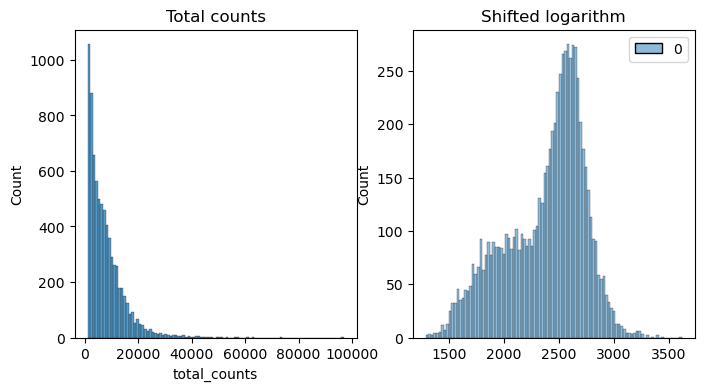

In [ ]:
%reset -f
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import yaml
import os
import seaborn as sns
import matplotlib.pyplot as plt

os.getcwd()
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
sc.settings.verbosity = 3

adata = ad.read_h5ad(f"data/{config['project_code']}_sc_after_qc.h5ad")
targets = pd.read_csv("data/targets.csv")
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

## 皮尔森近似残差

computing analytic Pearson residuals on adata.X
    finished (0:00:01)


/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/scanpy/experimental/pp/_normalization.py:76: RuntimeWarning: invalid value encountered in divide
  residuals = diff / np.sqrt(mu + mu**2 / theta)


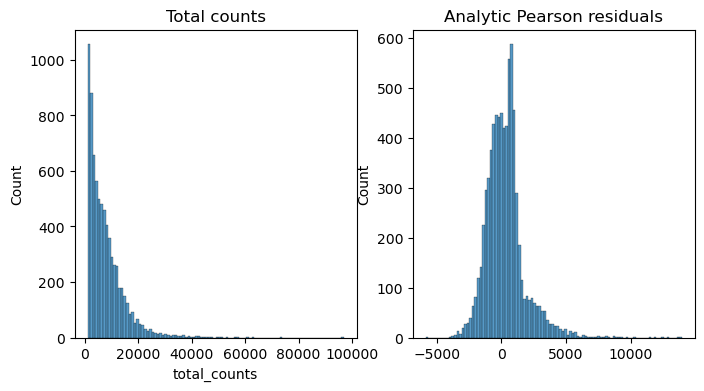

In [ ]:
from scipy.sparse import csr_matrix

analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
adata.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    np.nan_to_num(adata.layers["analytic_pearson_residuals"].toarray()).sum(axis=1),
    bins=100, kde=False, 
    ax=axes[1]
)
axes[1].set_title("Analytic Pearson residuals")
plt.show()

# 特征基因选择

## 数据加载与基因初筛
| 正则表达式                             | 基因来源                     | 删减原因                                               |
|----------------------------------------|------------------------------|--------------------------------------------------------|
| `^Gm`                                  | 小鼠预测基因（Gene models）  | 未经验证的自动注释基因，稳定性差，生物学意义不确定     |
| `Rik$`                                 | RIKEN 预测基因               | 功能未知，通常是日本理化研究所（RIKEN）命名的预测基因，分析中作用不明确 |
| `^CT\|^BC`                              | 克隆/文库构建编号             | 非标准基因名，无功能注释，可能为临时技术编号            |
| `Mir\|Ftx\|Tsix\|Firre\|Snhg\|Kcnq1ot1`     | 非编码 RNA（miRNA/lncRNA）   | 非编码转录本，常影响降维与聚类，部分调控基因             |
| `Eif2s3y\|Ddx3y\|Uty\|Kdm5d`              | Y 染色体基因                 | 男性特异性表达，可能引入性别偏倚                         |
| `^Rps\|^Rpl`                            | 核糖体蛋白基因               | 高表达背景噪音，主成分分析/聚类易受其主导                |
| `^mt-`                                 | 线粒体基因（小鼠）           | 线粒体表达高说明细胞可能死亡，常在 QC 时去除              |


In [ ]:
%reset -f
import scanpy as sc
import pandas as pd
import yaml
import os

display(os.getcwd())
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)


adata = sc.read(f"data/{config['project_code']}_sc_after_qc.h5ad")
#存储原始数据以便后续还原
adata.layers['counts']=adata.X.copy()

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers['log_norm']=adata.X.copy()

# 筛选前去掉有问题的基因
# 把所有基因名取出来
genes = adata.var_names

# 构建布尔掩码，保留你想保留的基因
mask = ~genes.str.match("^Gm") \
        & ~genes.str.endswith("Rik") \
        & ~genes.str.match("^CT|^BC") \
        & ~genes.str.contains("Mir|Ftx|Tsix|Firre|Snhg|Kcnq1ot1", case=False) \
        & ~genes.str.contains("Eif2s3y|Ddx3y|Uty|Kdm5d", case=False) \
        & ~genes.str.match("^Rps|^Rpl", case=False) \
        & ~genes.str.match("^mt-", case=False)

# 应用这个掩码来过滤基因
adata = adata[:, mask].copy()

'/Volumes/MacPassport/project/bioinfo/GSE233815'

normalizing counts per cell
    finished (0:00:00)


/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## 基于基因离散度

### 指定高可变基因数

In [28]:
adata_dis_num=sc.pp.highly_variable_genes(
    adata,
    flavor="seurat",
    n_top_genes=2000,
    subset=False,
    inplace=False,
)
adata_dis_num

extracting highly variable genes
    finished (0:00:00)


,means,dispersions,mean_bin,dispersions_norm,highly_variable
Xkr4,1.742460,1.522288,"(1.509, 1.811]",-0.389181,False
Rp1,0.001543,0.807675,"(-0.00601, 0.302]",0.376769,False
Sox17,0.032320,1.413608,"(-0.00601, 0.302]",1.667002,True
Mrpl15,0.132606,0.651793,"(-0.00601, 0.302]",0.044846,False
Lypla1,0.000339,-0.340446,"(-0.00601, 0.302]",-2.067959,False
...,...,...,...,...,...
Zfy1,0.000260,-0.117289,"(-0.00601, 0.302]",-1.592783,False
Uba1y,0.000939,0.831280,"(-0.00601, 0.302]",0.427032,False
Tspy-ps,0.000224,-0.974236,"(-0.00601, 0.302]",-3.417507,False
Usp9y,0.010580,1.949713,"(-0.00601, 0.302]",2.808545,True


### 指定基因离散度与平均度阈值

In [29]:
adata_dis_cutoff=sc.pp.highly_variable_genes(
    adata,
    flavor="seurat",
    min_disp=0.5,
    min_mean=0.0125,
    max_mean=3,
    subset=False,
    inplace=False,
)
adata_dis_cutoff['highly_variable'].value_counts()

extracting highly variable genes
    finished (0:00:00)


highly_variable
False    13826
True      2961
Name: count, dtype: int64

## 基于基因归一化方差

In [30]:
adata_var_num=sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    layer='counts',
    n_top_genes=2000,
    subset=False,
    inplace=False,
)
adata_var_num['highly_variable'].value_counts()

extracting highly variable genes


highly_variable
False    14787
True      2000
Name: count, dtype: int64

## 基于基因皮尔森近似残差

In [31]:
adata_pearson_num=sc.experimental.pp.highly_variable_genes(
    adata, 
    flavor="pearson_residuals",
    layer='counts',
    n_top_genes=2000,
    subset=False,
    inplace=False,
)
adata.var["highly_variable"] = adata_pearson_num["highly_variable"]
adata_pearson_num['highly_variable'].value_counts()

targets = pd.read_csv("data/targets.csv")
adata

extracting highly variable genes


AnnData object with n_obs × n_vars = 7457 × 16787
    obs: 'condition', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'passing_hb', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable'
    uns: 'scrublet', 'log1p'
    layers: 'counts', 'log_norm'

## 三种方法取得高变基因交集可视化

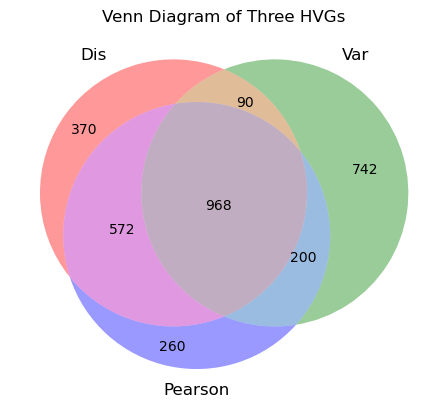

In [32]:
adata_dis_num.index=adata.var_names.copy()
adata_dis_cutoff.index=adata.var_names.copy()
adata_var_num.index=adata.var_names.copy()
adata_pearson_num.index=adata.var_names.copy()

import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# 三个列表的元素
list1 = set(adata_dis_num.loc[adata_dis_num['highly_variable']==True].index.tolist())
list2 = set(adata_var_num.loc[adata_var_num['highly_variable']==True].index.tolist())
list3 = set(adata_pearson_num.loc[adata_pearson_num['highly_variable']==True].index.tolist())

# 绘制 Venn 图
venn = venn3([list1, list2, list3], set_labels=('Dis', 'Var', 'Pearson'))

# 显示图形
plt.title("Venn Diagram of Three HVGs")
plt.show()

# 去除批次效应

## 预处理

In [ ]:
%reset -f
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import yaml
import os

os.getcwd()
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
sc.settings.verbosity = 3

adata = sc.read(f"data/{config['project_code']}_sc_after_qc.h5ad")
display(adata)
# 备份原始数据
adata.raw = adata.copy()

# 筛选前去掉有问题的基因
# 把所有基因名取出来
genes = adata.var_names
# 构建布尔掩码，保留你想保留的基因
mask = ~genes.str.match("^Gm") \
        & ~genes.str.endswith("Rik") \
        & ~genes.str.match("^CT|^BC") \
        & ~genes.str.contains("Mir|Ftx|Tsix|Firre|Snhg|Kcnq1ot1", case=False) \
        & ~genes.str.contains("Eif2s3y|Ddx3y|Uty|Kdm5d", case=False) \
        & ~genes.str.match("^Rps|^Rpl", case=False) \
        & ~genes.str.match("^mt-", case=False)
# 应用这个掩码来过滤基因
adata = adata[:, mask].copy()

# 归一化
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
# 筛选高可变基因
# batch_key:按样本筛选高变基因
sc.pp.highly_variable_genes(adata, n_top_genes=1000, batch_key="sample")
# highly_variable_nbatches：哪一个样本的batch中出现的hvg，0代表非hvg
adata = adata[:, adata.var.highly_variable]
# 输出高变基因供查找
pd.Series(adata.var.index).to_csv("data/hvg.csv")

/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 7457 × 24277
    obs: 'condition', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'passing_hb', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet'

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


## harmony去除批次效应

In [ ]:
# harmony
sc.tl.pca(adata, n_comps=50)
# 包的作者停止维护了，如果不能安装，强制安装即可
# pip install harmonypy (--no-deps)
sce.pp.harmony_integrate(adata=adata, key='sample',
                         basis='X_pca',
                         adjusted_basis='X_pca_harmony')
# umap
sc.pp.neighbors(adata=adata, use_rep='X_pca_harmony')
sc.tl.umap(adata=adata)
# tsne
sc.tl.tsne(adata=adata, use_rep='X_pca_harmony')
display(adata)
adata.write(f"data/{config['project_code']}_sc_cluster.h5ad")
adata.obsm

computing PCA
    with n_comps=50
    finished (0:00:00)


/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:383: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
2025-07-09 10:18:37,116 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-07-09 10:18:38,871 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-07-09 10:18:38,893 - harmonypy - INFO - Iteration 1 of 10
2025-07-09 10:18:39,706 - harmonypy - INFO - Iteration 2 of 10
2025-07-09 10:18:40,590 - harmonypy - INFO - Iteration 3 of 10
2025-07-09 10:18:41,170 - harmonypy - INFO - Converged after 3 iterations


computing neighbors


/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:06)
computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm)
    'tsne', tSNE parameters (adata.uns) (0:00:13)


AnnData object with n_obs × n_vars = 7457 × 1000
    obs: 'condition', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'passing_hb', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'tsne'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

AxisArrays with keys: X_pca, X_pca_harmony, X_umap, X_tsne

## 可视化

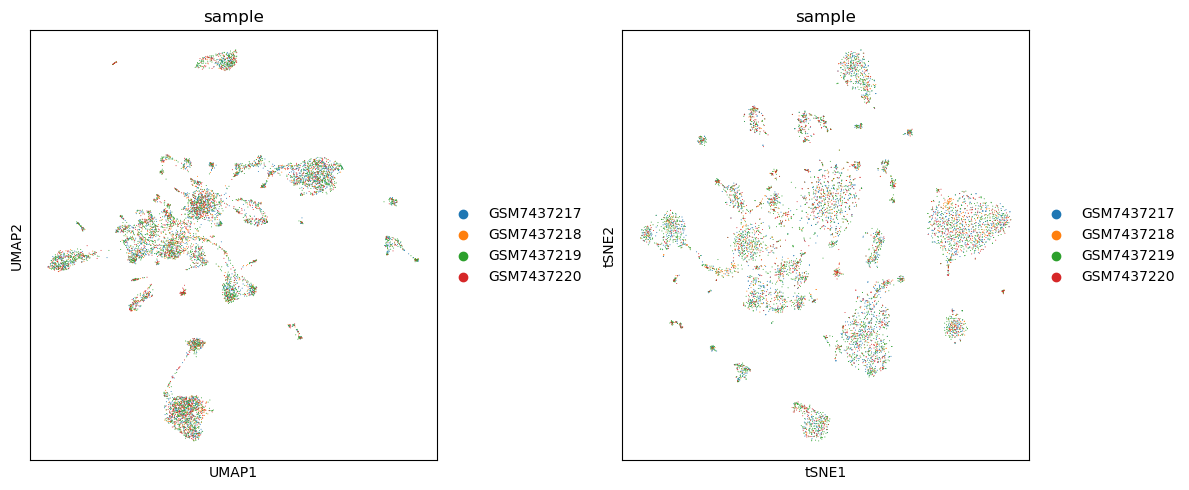

In [35]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sc.pl.umap(adata, color="sample", size=2, ax=ax1, show=False)
sc.pl.tsne(adata, color="sample", size=2, ax=ax2, show=False)
plt.tight_layout()
plt.show()

# 聚类

## 预处理

In [ ]:
%reset -f
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import os

display(os.getcwd())
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
sc.settings.verbosity = 3

adata = sc.read(f"data/{config['project_code']}_sc_cluster.h5ad")

'/Volumes/MacPassport/project/bioinfo/GSE233815'

/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## 基于leiden算法的聚类

In [37]:
for res in [0.25, 0.5, 1, 1.5, 2]:
    sc.tl.leiden(adata, flavor="igraph", directed=False, resolution=res, key_added=f"leiden_res{res}",)

adata.write(f"data/{config['project_code']}_cluster.h5ad")

running Leiden clustering
    finished: found 20 clusters and added
    'leiden_res0.25', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 23 clusters and added
    'leiden_res0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 30 clusters and added
    'leiden_res1', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 36 clusters and added
    'leiden_res1.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 41 clusters and added
    'leiden_res2', the cluster labels (adata.obs, categorical) (0:00:00)


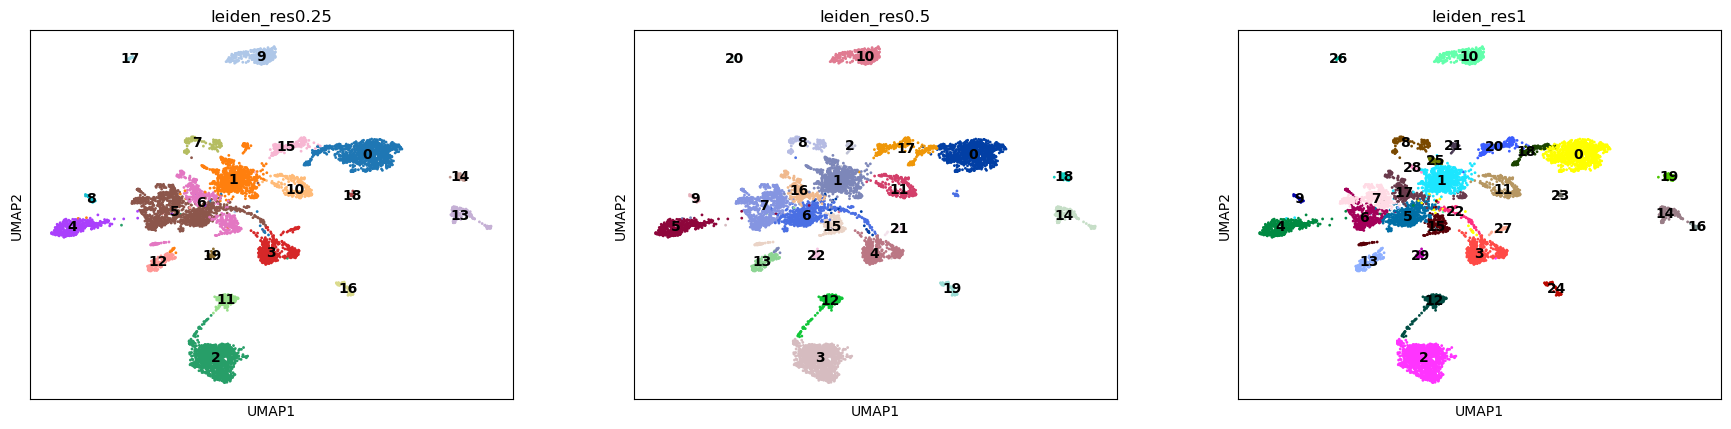

In [38]:
key = ["leiden_res0.25", "leiden_res0.5",  "leiden_res1"]
# sc.pl.umap(adata, color=key, save=f"_cluster.pdf")
# sc.pl.tsne(adata, color=key, save=f"_cluster.pdf")
sc.pl.umap(adata, legend_loc='on data', color=key, save=f"_leiden_res1_on_data_cluster.pdf")
# sc.pl.tsne(adata, legend_loc='on data', color=['leiden_res1', 'leiden_res0.5'], save=f"_leiden_res1_on_data_cluster.pdf")

# 细胞类型注释

## 自动注释（基于reference）

In [40]:
%reset -f
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import json
import os

import celltypist
from celltypist import models
# 显示所有模型列表
display(models.models_description())
# # 下载指定模型
# models.download_models(model = ['Mouse_Whole_Brain.pkl',
#                                 'Mouse_Isocortex_Hippocampus.pkl',
#                                 'Developing_Mouse_Brain.pkl',
#                                 'Immune_All_High.pkl', 'Immune_All_Low.pkl'], 
#                        force_update = True)

os.getcwd()
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
sc.settings.verbosity = 3

adata = sc.read(f"data/{config['project_code']}_cluster.h5ad")
# 输出所有基因名供查找
pd.DataFrame({"name":adata.var.index}).to_csv("data/all_genes.csv")
adata.obs = adata.obs.loc[:, ['sample', 'leiden_res0.25', 'leiden_res0.5', 'leiden_res1', 'leiden_res1.5', 'leiden_res2']]
adata.var = adata.var.loc[:, []]
adata

👉 Detailed model information can be found at `https://www.celltypist.org/models`


,model,description
0,Immune_All_Low.pkl,immune sub-populations combined from 20 tissue...
1,Immune_All_High.pkl,immune populations combined from 20 tissues of...
2,Adult_COVID19_PBMC.pkl,peripheral blood mononuclear cell types from C...
3,Adult_CynomolgusMacaque_Hippocampus.pkl,cell types from the hippocampus of adult cynom...
4,Adult_Human_MTG.pkl,cell types and subtypes (10x-based) from the a...
5,Adult_Human_PancreaticIslet.pkl,cell types from pancreatic islets of healthy a...
6,Adult_Human_PrefrontalCortex.pkl,cell types and subtypes from the adult human d...
7,Adult_Human_Skin.pkl,cell types from human healthy adult skin
8,Adult_Human_Vascular.pkl,vascular populations combined from multiple ad...
9,Adult_Mouse_Gut.pkl,cell types in the adult mouse gut combined fro...


AnnData object with n_obs × n_vars = 7457 × 1000
    obs: 'sample', 'leiden_res0.25', 'leiden_res0.5', 'leiden_res1', 'leiden_res1.5', 'leiden_res2'
    uns: 'hvg', 'leiden_res0.25', 'leiden_res0.5', 'leiden_res1', 'leiden_res1.5', 'leiden_res2', 'log1p', 'neighbors', 'pca', 'scrublet', 'tsne', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Mouse_Whole_Brain.pkl模型是基于文章：[A high-resolution transcriptomic and spatial atlas of cell types in the whole mouse brain](https://pubmed.ncbi.nlm.nih.gov/38092916)

关于缩写可以参照文章补充材料表7, 表格已同步至endnote

In [41]:
# 加载小鼠全脑模型
model = models.Model.load(model = 'Mouse_Whole_Brain.pkl')
predictions = celltypist.annotate(adata, model = 'Mouse_Whole_Brain.pkl')
display(predictions)
dotplot = celltypist.dotplot(predictions, use_as_reference = "leiden_res1", use_as_prediction = 'predicted_labels',
                             reference_order=[f"{i}" for i in range(0,adata.obs["leiden_res1"].astype(int).max()+1)],
                             return_fig=True)
dotplot.savefig("figures/auto_annotation_dotplot_Mouse_Whole_Brain.pdf")
plt.close()

⚠️ Warning: invalid expression matrix, expect ALL genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 7457 cells and 1000 genes
🔗 Matching reference genes in the model


🧬 747 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


CellTypist prediction result for 7457 query cells
    predicted_labels: data frame with 1 column ('predicted_labels')
    decision_matrix: data frame with 7457 query cells and 334 cell types
    probability_matrix: data frame with 7457 query cells and 334 cell types
    adata: AnnData object referred

TypeError: unhashable type: 'Series'

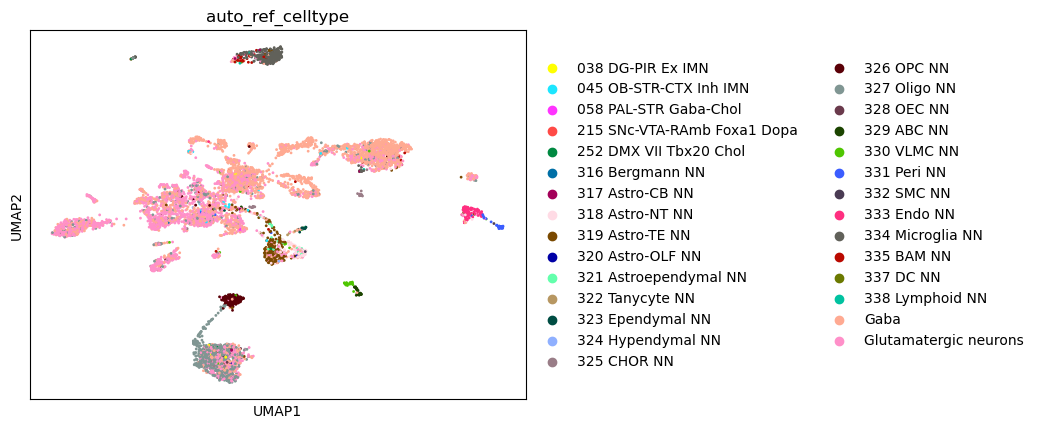

AnnData object with n_obs × n_vars = 7457 × 1000
    obs: 'sample', 'leiden_res0.25', 'leiden_res0.5', 'leiden_res1', 'leiden_res1.5', 'leiden_res2', 'predicted_labels', 'conf_score', 'auto_ref_celltype'
    uns: 'hvg', 'leiden_res0.25', 'leiden_res0.5', 'leiden_res1', 'leiden_res1.5', 'leiden_res2', 'log1p', 'neighbors', 'pca', 'scrublet', 'tsne', 'umap', 'auto_ref_celltype_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

,sample,leiden_res0.25,leiden_res0.5,leiden_res1,leiden_res1.5,leiden_res2,predicted_labels,conf_score,auto_ref_celltype
AAACCCAAGCTCTATG,GSM7437217,0,0,0,0,0,061 STR D1 Gaba,0.004684,Gaba
AAACCCACAAACTAAG,GSM7437217,1,1,1,1,2,061 STR D1 Gaba,0.008717,Gaba
AAACGAACAATCCTAG,GSM7437217,2,3,2,2,5,327 Oligo NN,0.165176,327 Oligo NN
AAACGAACAATTCTTC,GSM7437217,3,4,3,3,7,073 MEA-BST Sox6 Gaba,0.049445,Gaba
AAACGCTGTGCTGTCG,GSM7437217,4,5,4,5,8,061 STR D1 Gaba,0.003595,Gaba
...,...,...,...,...,...,...,...,...,...
TTTGATCAGCGACTGA,GSM7437220,5,7,7,7,14,243 PGRN-PARN-MDRN Hoxb5 Glut,0.002147,Glutamatergic neurons
TTTGATCCATAGGCGA,GSM7437220,9,10,10,11,15,334 Microglia NN,0.178653,334 Microglia NN
TTTGGAGGTAGGCAGT,GSM7437220,0,0,0,0,1,061 STR D1 Gaba,0.009205,Gaba
TTTGGAGTCTCCATAT,GSM7437220,0,17,18,23,27,060 OT D3 Folh1 Gaba,0.001700,Gaba


In [42]:
adata_auto = predictions.to_adata()

adata_auto.obs.loc[:,"auto_ref_celltype"] = adata_auto.obs.loc[:,'predicted_labels'].str.replace(r'.*Glut$', 'Glutamatergic neurons', regex=True).astype("category")
adata_auto.obs.loc[:,"auto_ref_celltype"] = adata_auto.obs.loc[:,'auto_ref_celltype'].str.replace(r'.*Gaba$', 'Gaba', regex=True).astype("category")
sc.pl.umap(adata_auto, color="auto_ref_celltype", save=f"_auto_annotation_cluster.pdf")
# sc.pl.tsne(adata_auto, color="auto_ref_celltype", save=f"_auto_annotation_cluster.pdf")
display(adata_auto)

adata_auto.write(f"data/{config['project_code']}_annotated.h5ad")
adata_auto.obs

In [43]:
df = adata.obs[['leiden_res1', 'auto_ref_celltype']].copy()

# # 按 leiden_res1 聚类，统计 auto_ref_celltype 的出现次数
# top3_per_cluster = df.groupby('leiden_res1')['auto_ref_celltype'].value_counts().groupby('leiden_res1').head(3).reset_index(name='count')

# # 转换为宽表格式，列出每个簇的前三个 celltype
# pivot_table = top3_per_cluster.pivot_table(index='leiden_res1', columns='auto_ref_celltype', values='count', aggfunc='first').fillna(0)
top3_names = df.groupby('leiden_res1')['auto_ref_celltype'].value_counts().groupby('leiden_res1').head(3).reset_index().loc[:,['leiden_res1', 'auto_ref_celltype']]
result = top3_names.groupby('leiden_res1').agg(list).reset_index()
result.columns = ['leiden_res1', 'Top 3 auto_ref_celltype']
result.to_csv('figures/top3_auto_ref_celltype_per_leiden_res1.csv', index=False)
print(result)

   leiden_res1                            Top 3 auto_ref_celltype
0            0        [Gaba, Glutamatergic neurons, 327 Oligo NN]
1            1        [Gaba, Glutamatergic neurons, 327 Oligo NN]
2            2        [327 Oligo NN, Glutamatergic neurons, Gaba]
3            3           [319 Astro-TE NN, 318 Astro-NT NN, Gaba]
4            4        [Glutamatergic neurons, Gaba, 327 Oligo NN]
5            5        [Glutamatergic neurons, Gaba, 327 Oligo NN]
6            6        [Glutamatergic neurons, Gaba, 327 Oligo NN]
7            7        [Glutamatergic neurons, Gaba, 327 Oligo NN]
8            8  [Gaba, Glutamatergic neurons, 045 OB-STR-CTX I...
9            9         [Glutamatergic neurons, Gaba, 325 CHOR NN]
10          10               [334 Microglia NN, 335 BAM NN, Gaba]
11          11        [Gaba, Glutamatergic neurons, 327 Oligo NN]
12          12  [326 OPC NN, 327 Oligo NN, Glutamatergic neurons]
13          13        [Glutamatergic neurons, Gaba, 327 Oligo NN]
14        

In [44]:
# # 加载小鼠胚胎脑模型
# model = models.Model.load(model = 'Developing_Mouse_Brain.pkl')
# predictions = celltypist.annotate(adata, model = 'Developing_Mouse_Brain.pkl')
# display(predictions)
# dotplot = celltypist.dotplot(predictions, use_as_reference = "leiden_res1", use_as_prediction = 'predicted_labels',
#                              reference_order=[f"{i}" for i in range(0,adata.obs["leiden_res1"].astype(int).max()+1)],
#                              return_fig=True)
# dotplot.savefig("figures/auto_annotation_dotplot_Developing_Mouse_Brain.pdf")

In [45]:
# # 加载小鼠胚胎脑模型
# model = models.Model.load(model = 'Immune_All_Low.pkl')
# predictions = celltypist.annotate(adata, model = 'Immune_All_Low.pkl')
# display(predictions)
# dotplot = celltypist.dotplot(predictions, use_as_reference = "leiden_res1", use_as_prediction = 'predicted_labels',
#                              reference_order=[f"{i}" for i in range(0,adata.obs["leiden_res1"].astype(int).max()+1)],
#                              return_fig=True)
# dotplot.savefig("figures/auto_annotation_dotplot_Immune_All_High.pdf")

## 预处理（逐细胞簇差异分析）

In [48]:
%reset -f
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import os

os.getcwd()
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
sc.settings.verbosity = 3

adata = sc.read(f"data/{config['project_code']}_annotated.h5ad")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


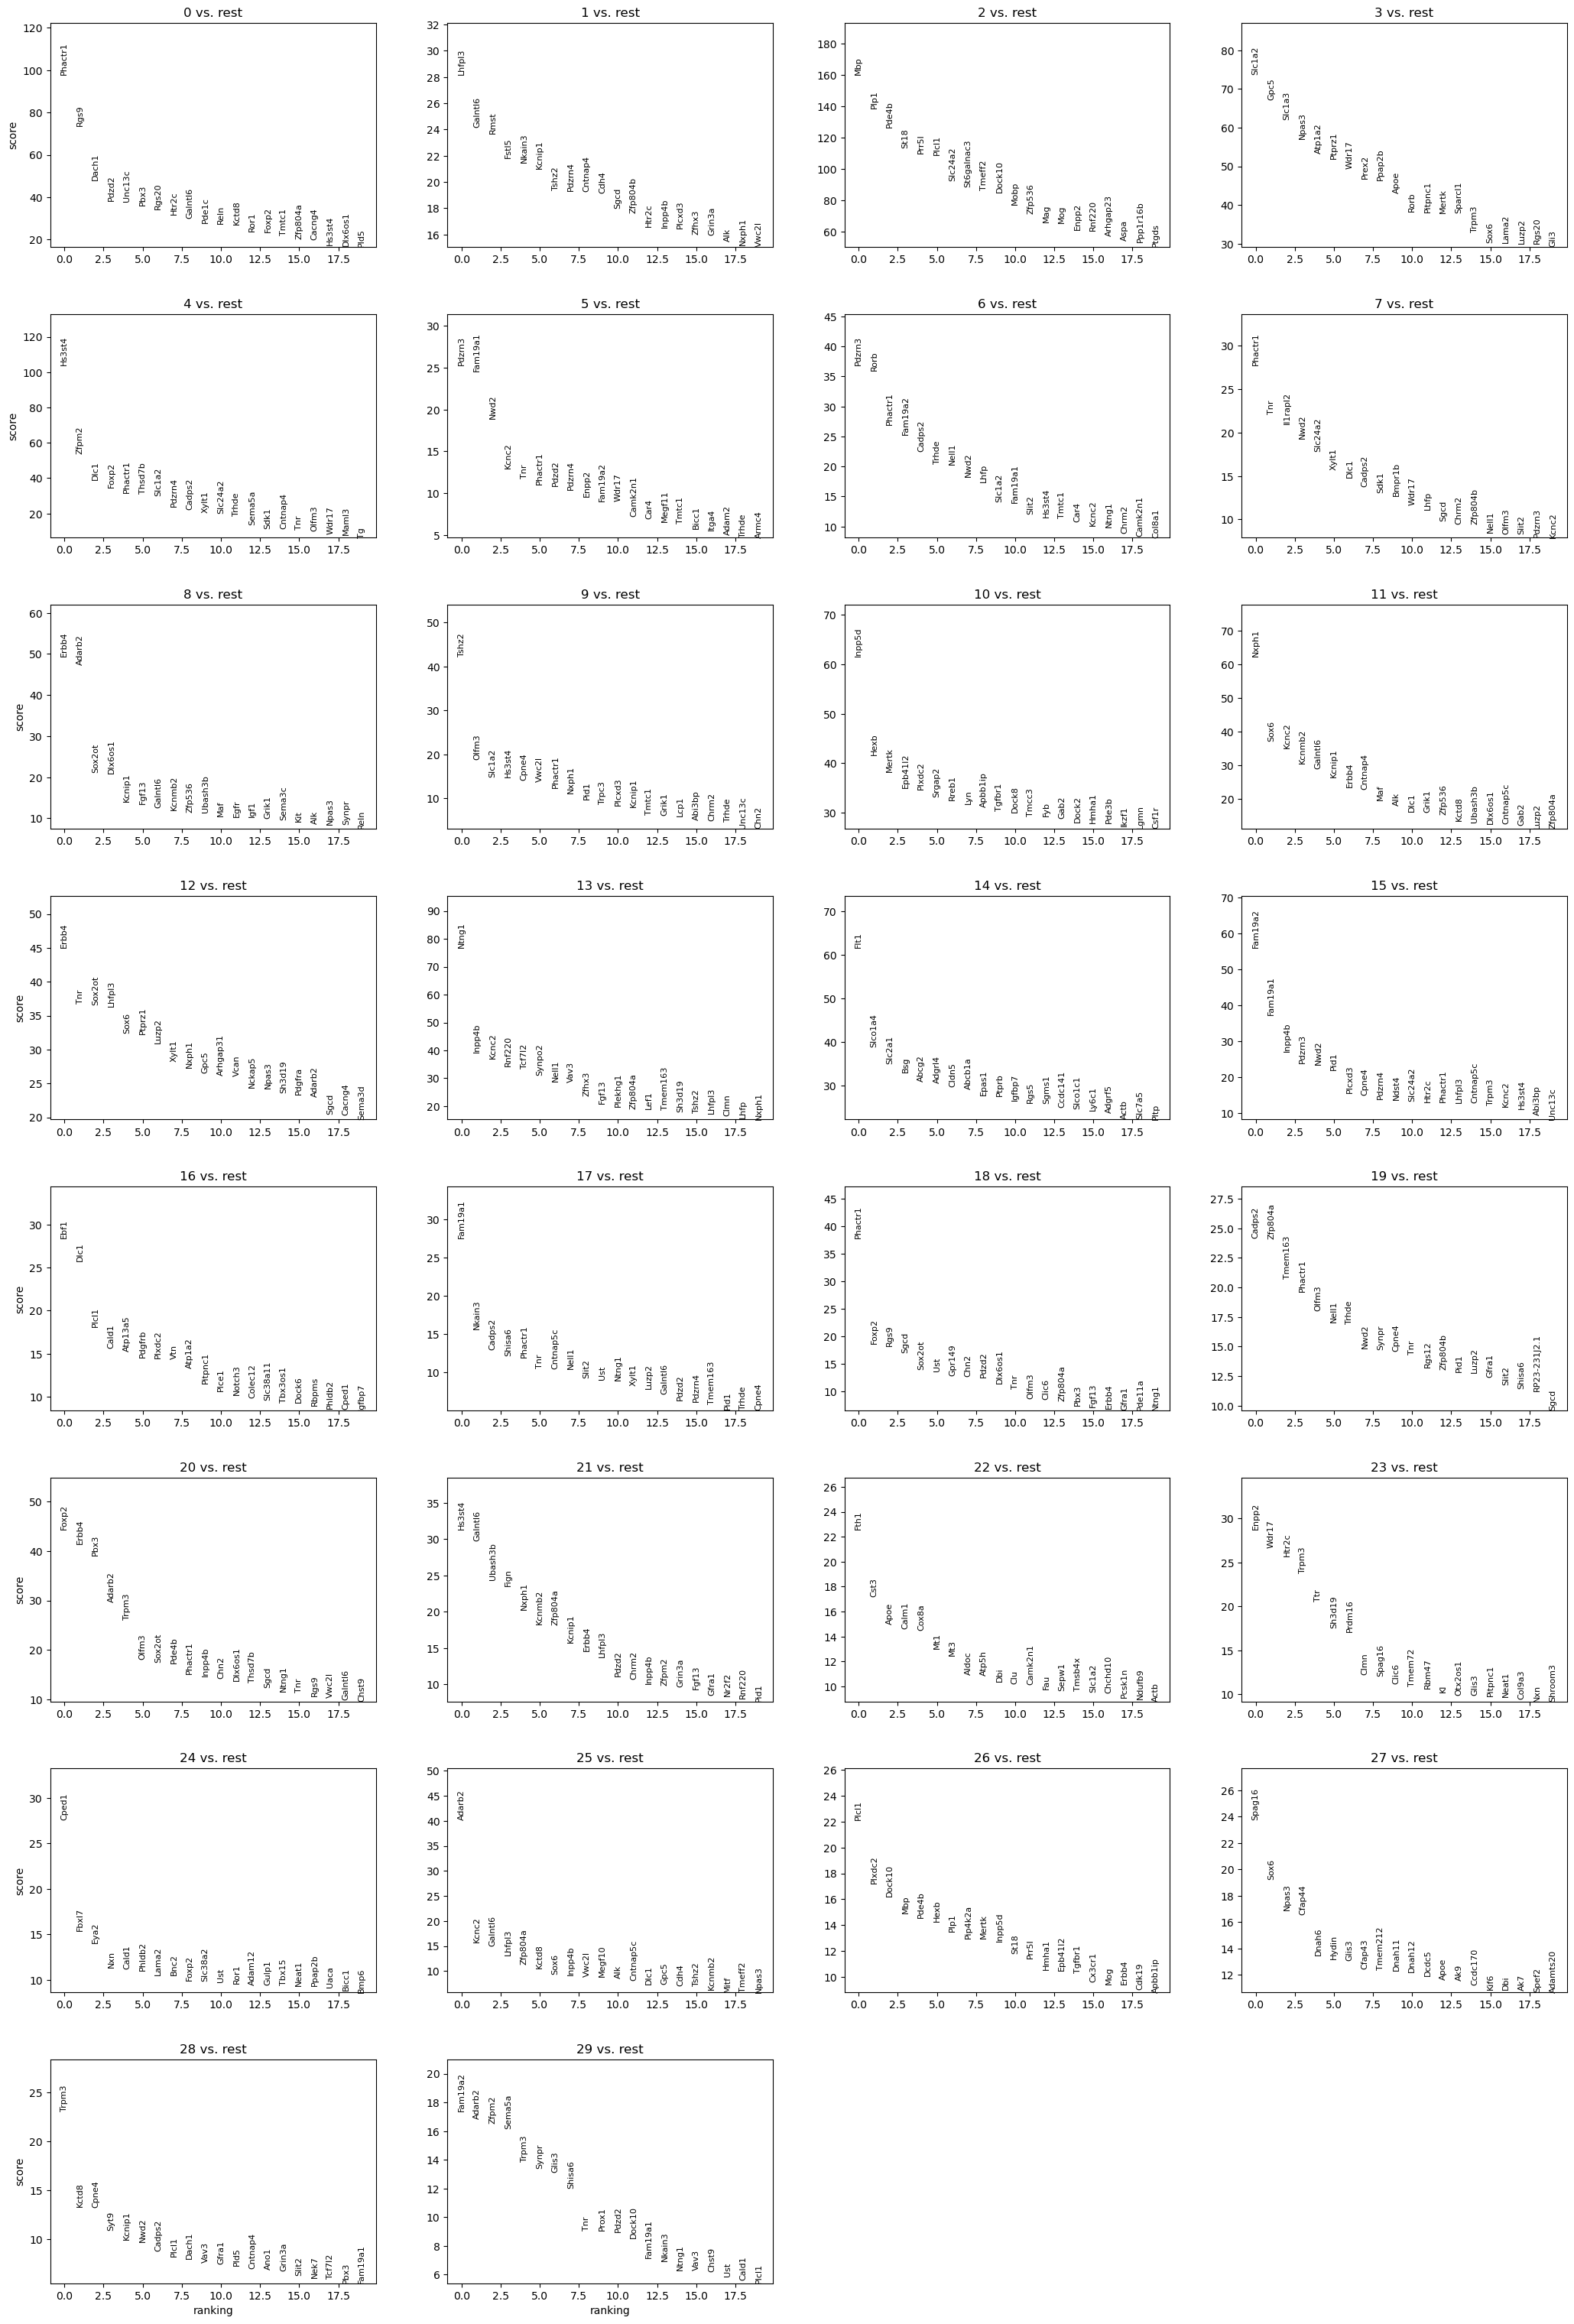

In [49]:
import warnings
warnings.filterwarnings('ignore')
# 找不到分群的时候查一下
adata_rank = sc.tl.rank_genes_groups(adata, "leiden_res1", method="t-test", use_raw=False, copy=True, pts=True)
# 结果存储在adata_rank.uns['rank_genes_groups']['names']
# 可视化分群结果
sc.pl.rank_genes_groups(adata_rank, n_genes=20, sharey=False)

if not os.path.exists("result/deg_by_leiden_cluster"):
    os.makedirs("result/deg_by_leiden_cluster")

for celltype in adata_rank.uns['rank_genes_groups']["names"].dtype.names:
    res = pd.DataFrame({'names': adata_rank.uns['rank_genes_groups']["names"][celltype], 
                        'scores': adata_rank.uns['rank_genes_groups']["scores"][celltype],
                        'pvals': adata_rank.uns['rank_genes_groups']["pvals"][celltype],
                        'pvals_adj': adata_rank.uns['rank_genes_groups']["pvals_adj"][celltype],
                        'log2foldchanges': adata_rank.uns['rank_genes_groups']["logfoldchanges"][celltype]})
    res = res.sort_values(by=["pvals","log2foldchanges"], ascending=[True,False])
    mask = (res['log2foldchanges'].abs() > 1) & (res['pvals'] < 0.1)
    res.loc[mask,:].to_csv(f"result/deg_by_leiden_cluster/deg_of_{celltype}.tsv", index=None, sep="\t")

# 重置warning
warnings.resetwarnings()
# 保存差异分析结果
adata_rank.write(f"data/{config['project_code']}_annotated.h5ad")

## 自动注释（基于marker+聚类）

### 基于CellMarker提供的marker信息

In [51]:
%reset -f
import sys
sys.path.append(r"/Volumes/MacPassport/project/omictools")
import omictools as otl
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import SCINApy as scina
import json
import os

os.getcwd()
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
sc.settings.verbosity = 3

adata = sc.read(f"data/{config['project_code']}_annotated.h5ad")
display(adata)

marker_database = otl.tp.CellMarker(species="Mouse", tissue_class="Brain", cancer_type="Normal")
marker_dict = marker_database.marker_dict
# 键名为细胞名，值为基因名
marker_dict['Glial cell']

/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 7457 × 1000
    obs: 'sample', 'leiden_res0.25', 'leiden_res0.5', 'leiden_res1', 'leiden_res1.5', 'leiden_res2', 'predicted_labels', 'conf_score', 'auto_ref_celltype'
    uns: 'auto_ref_celltype_colors', 'hvg', 'leiden_res0.25', 'leiden_res0.5', 'leiden_res1', 'leiden_res1.5', 'leiden_res2', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'scrublet', 'tsne', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

['S100a1', 'Mki67', 'Gfap', 'Vim', 'Tnc', 'Egfr', 'Plp1', 'Sox10']

#### 基因计数

In [52]:
# 只看最显著的top多少基因
top = 40
rank_res = pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).loc[0:top-1,:]

similarity_score = pd.DataFrame(np.zeros((len(marker_dict.keys()),rank_res.shape[1])), index=list(marker_dict.keys()))
# 
for celltype, markers in marker_dict.items():
    for col in rank_res.columns:
        inter_gene_count = len(set(rank_res.loc[:,col])&set(markers))
        marker_dict_count = len(set(markers))
        # 使用交集在字典基因集占比和top200rank基因集占比的几何平均
        # similarity_score.loc[celltype, col] = inter_gene_count / np.sqrt(top * marker_dict_count)
        # 使用交集大小
        similarity_score.loc[celltype, col] = inter_gene_count

adata.obs.loc[:,"auto_marker_celltype"] = [similarity_score.idxmax()[i] for i in adata.obs.loc[:,"leiden_res1"].astype("O")]
# 删除所有行总和为 0 的行
similarity_score.loc[similarity_score.sum(axis=1) != 0]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
Activated neural stem cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Astrocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.0,16.0,7.0,6.0,2.0,0.0,3.0,2.0,3.0
Astroglial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Basket cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vascular endothelial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Vascular leptomeningeal cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Vascular smooth muscle cell(VSMC),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Venous cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


#### SCINA

In [53]:
# 保存 cell_marker_dict 到 JSON 文件
with open("data/cell_marker_dict.json", "w", encoding="utf-8") as f:
    json.dump(marker_dict, f, ensure_ascii=False, indent=4)

# 将 adata.X 转换为 numpy 数组
data_matrix = adata.X.toarray()
# 获取 Leiden 簇标签
clusters = adata.obs["leiden_res1"].astype(str)
unique_clusters = np.unique(clusters)

# 初始化列表用于存储抽样数据和对应的簇标签
sample_size = 20
sampled_data = []
sampled_leiden = []

# 对每个簇进行随机抽样
for cluster in unique_clusters:
    mask = clusters == cluster
    cluster_indices = np.where(mask)[0]
    
    # 检查簇中的细胞数量
    if len(cluster_indices) >= sample_size:
        # 随机抽样 20 个细胞
        sampled_indices = np.random.choice(cluster_indices, size=sample_size, replace=False)
    else:
        # 如果细胞数量不足 20 个，使用所有细胞
        sampled_indices = cluster_indices
    
    # 提取抽样细胞的数据和对应的簇标签
    sampled_data.append(data_matrix[sampled_indices, :])
    sampled_leiden.extend([cluster] * len(sampled_indices))

# 将抽样数据合并为矩阵
sampled_matrix = np.vstack(sampled_data)

# 创建 obs DataFrame，包含 leiden 列
obs_df = pd.DataFrame({
    "leiden": sampled_leiden
})

# 创建新的 AnnData 对象
adata_avg = ad.AnnData(
    X=sampled_matrix,
    obs=obs_df,
    var=adata.var.copy()
)

scina.SCINA(adata=adata_avg, signatures=marker_dict, inplace=True)

/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/SCINApy/core.py:333: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(exponent_term, dtype=np.float64)
/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/SCINApy/core.py:333: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(exponent_term, dtype=np.float64)
/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/SCINApy/core.py:333: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(exponent_term, dtype=np.float64)
/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/SCINApy/core.py:333: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(exponent_term, dtype=np.float64)
/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/SCINApy/core.py:333: RuntimeWarning: overfl

In [54]:
# 按第一列分组，找到第二列出现最多次的标签
result = adata_avg.obs.groupby('leiden')['scina_labels'].agg(lambda x: x.value_counts().idxmax())
# 初始化
adata.obs.loc[:, "scina_cellmarker_label"] = ""

# 逐个输出结果
for leiden, label in result.items():
    adata.obs.loc[adata.obs['leiden_res1']==leiden, "scina_cellmarker_label"]=str(label)
    print(f"{leiden}: {label}")

0: Cajal-Retzius cell
1: Type I spiral ganglion neuron
10: Microglial cell
11: Type I spiral ganglion neuron
12: Oligodendrocyte precursor cell
13: Type IC spiral ganglion neuron
14: Endothelial cell
15: Long-projecting GABAergic cell
16: Smooth muscle cell
17: Martinotti cell
18: Martinotti cell
19: Type I spiral ganglion neuron
2: Oligodendrocyte
20: Type IC spiral ganglion neuron
21: Type I spiral ganglion neuron
22: Astrocyte
23: Schwann cell
24: Vascular cell
25: Type I spiral ganglion neuron
26: Microglial cell
27: Ependymal cell
28: Type II spiral ganglion neuron
29: GABAergic neuron
3: Astrocyte
4: GABAergic neuron
5: Bergmann glial cell
6: Primary motor cortex cell
7: Martinotti cell
8: Cajal-Retzius cell
9: Type I spiral ganglion neuron


... storing 'auto_marker_celltype' as categorical
... storing 'scina_cellmarker_label' as categorical


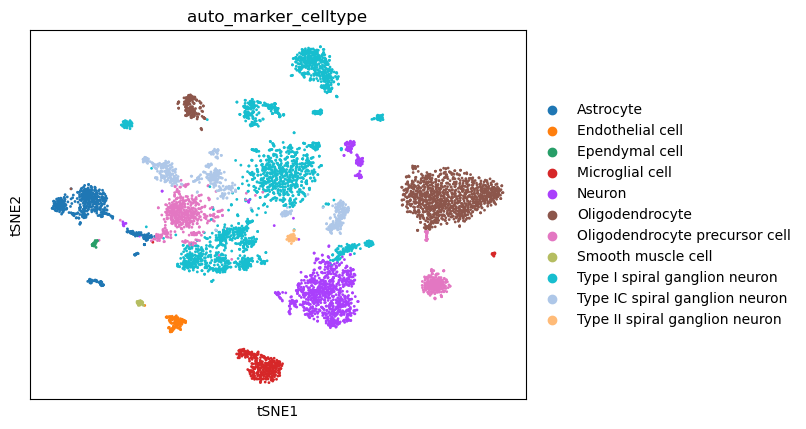

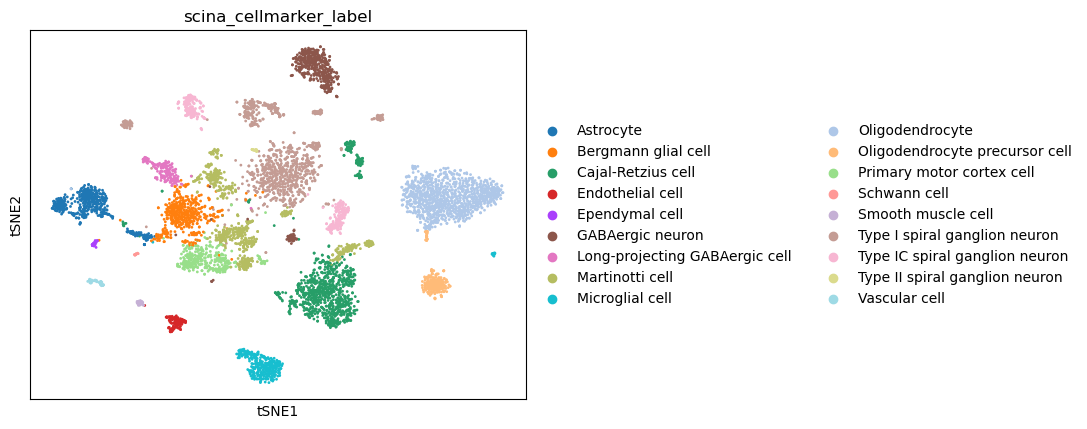

In [55]:
sc.pl.tsne(adata, color="auto_marker_celltype", save=f"_auto_marker_cluster.pdf")
sc.pl.tsne(adata, color="scina_cellmarker_label", save=f"_auto_marker_cluster.pdf")
adata.write(f"data/{config['project_code']}_annotated.h5ad")
# rank_res.to_csv("data/rank_gene_top200.tsv", sep="\t", index=None)

### 基于经验marker的标注结果

|分组|细胞类型|基因|
|----|-------|----|
|血液|Erythroid progenitor cell|['Adgre1','Csf1r','Epor','Gata1','Gypa','Klf1','Hbb-a1']|
|血液|Immune cell|["Ccr7","Cd11b","Cd3","Cd3d","Cd3e","Cd3g","Cd4","Ptprc","Cd74","Cd79a","Cd8","Cd83"]|
|血液|T cell|["Cd3d", "Cd3e", "Cd3g"]|
|血液|B cell|["Cd79a","Ms4a1","Cd19"]|
|血液|Dendritic cell|["Clec9a", "Flt3", "Zbtb46"]|
|血液|Monocyte|['Ly6c2','Ccr2','Cd68']|
|血液|Macrophage|["Iba1", "Mrc1", "Cd68", "F13a1","Itgam"]|
|血液|Neutrophil|["Lcn2", "Ly6g", "S100a8","Mmp8","Mmp9"]|
|血液|Mast cell|["Kit","Tpsb2","Tpsab1"]|
|血脑屏障及其附属结构|Vascular cells|["Myl9", "Mgp46"]|
|血脑屏障及其附属结构|Vascular endothelial cell|["Cldn5","Pecam1","Cdh5","Slc38a5"]|
|血脑屏障及其附属结构|Vascular smooth muscle cell|["Myh11","Acta2","Tagln","Rgs5"]|
|血脑屏障及其附属结构|Endothelial cell|["Esam"]|
|血脑屏障及其附属结构|Pericyte|["Rgs5","Abcc9","Kcnj8","Pdgfrb"]|
|血脑屏障及其附属结构|Fibroblast|["Col1a1","Dcn","Pdgfra","Col3a1"]|
|血脑屏障及其附属结构|Schwann cell|["Mbp","Ttr"]|
|血脑屏障及其附属结构|Choroid cells|["Lcn2"]|
|血脑屏障及其附属结构|Choroid plexus cell|["Folr1"]|
|血脑屏障及其附属结构|Ependymal cell|['Ccdc153','Foxj1','Tmem212','Dnah11','Ccdc153','Foxj1','Tmem212','Dnah11']|
|脑实质组织|Oligodendrocyte|["Mbp", "Mog","Olig2","Olig1","Plp1","Mag","Cldn11"]|
|脑实质组织|Oligodendrocyte progenitor cell|["Pdgfra", "Ascl1", "Dcn", "Ednrb","Ng2"]|
|脑实质组织|Oligodendrocyte precursor cell|["Pdgfra", "Olig1","Cacng4","Olig2","Sox10"]|
|脑实质组织|Microglial cell|["Tmem119","Cx3cr1","P2ry12","Iba1","Csf1r","C1qa","Cd11b","Itgam","Fcrls","Cd68","Aif1","Sall1","Hexb","F11r"]|
|脑实质组织|Astrocyte|["Gfap", "Aqp4", "Gja1"]|
|脑实质组织|Neuron|["Rbfox3","Snap25","Map2","Tubb3","Stmn2","Dcx"]|

In [57]:
%reset -f
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import json
import os

os.getcwd()
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
sc.settings.verbosity = 3

adata = sc.read(f"data/{config['project_code']}_annotated.h5ad")

# 加载小字典
with open("data/small_marker_dict.json", "r", encoding="utf-8") as f:
    small_marker_dict = json.load(f)

# 对比微型细胞类型标注字典，留下存在于测序数据中的marker基因
# 这里一定要在raw矩阵中搜索，否则可能会因为质控的hvg筛选而搜不到基因
smarker_genes_in_data = dict()
for celltype, markers in small_marker_dict.items():
    markers_found = list()
    for marker in markers:
        if marker in adata.raw.var.index:
            markers_found.append(marker)
    smarker_genes_in_data[celltype] = markers_found

# 除去不包含任何marker基因值的细胞类型键
del_markers = list()
for celltype, markers in smarker_genes_in_data.items():
    if markers==[]:
        del_markers.append(celltype)
for celltype in del_markers:
    del smarker_genes_in_data[celltype]

smarker_genes_in_data.keys()

/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


dict_keys(['Erythroid progenitor cell', 'Immune cell', 'T cell', 'B cell', 'Dendritic cell', 'Macrophage', 'Neutrophil', 'Vascular cells', 'Vascular endothelial cell', 'Vascular smooth muscle cell', 'Endothelial cell', 'Pericyte', 'Fibroblast', 'Schwann cell', 'Choroid plexus cell', 'Ependymal cell', 'Oligodendrocyte', 'Oligodendrocyte progenitor cell', 'Oligodendrocyte precursor cell', 'Microglial cell', 'Astrocyte', 'Neuron'])

#### 可视化所有细胞群中marker基因的表达情况

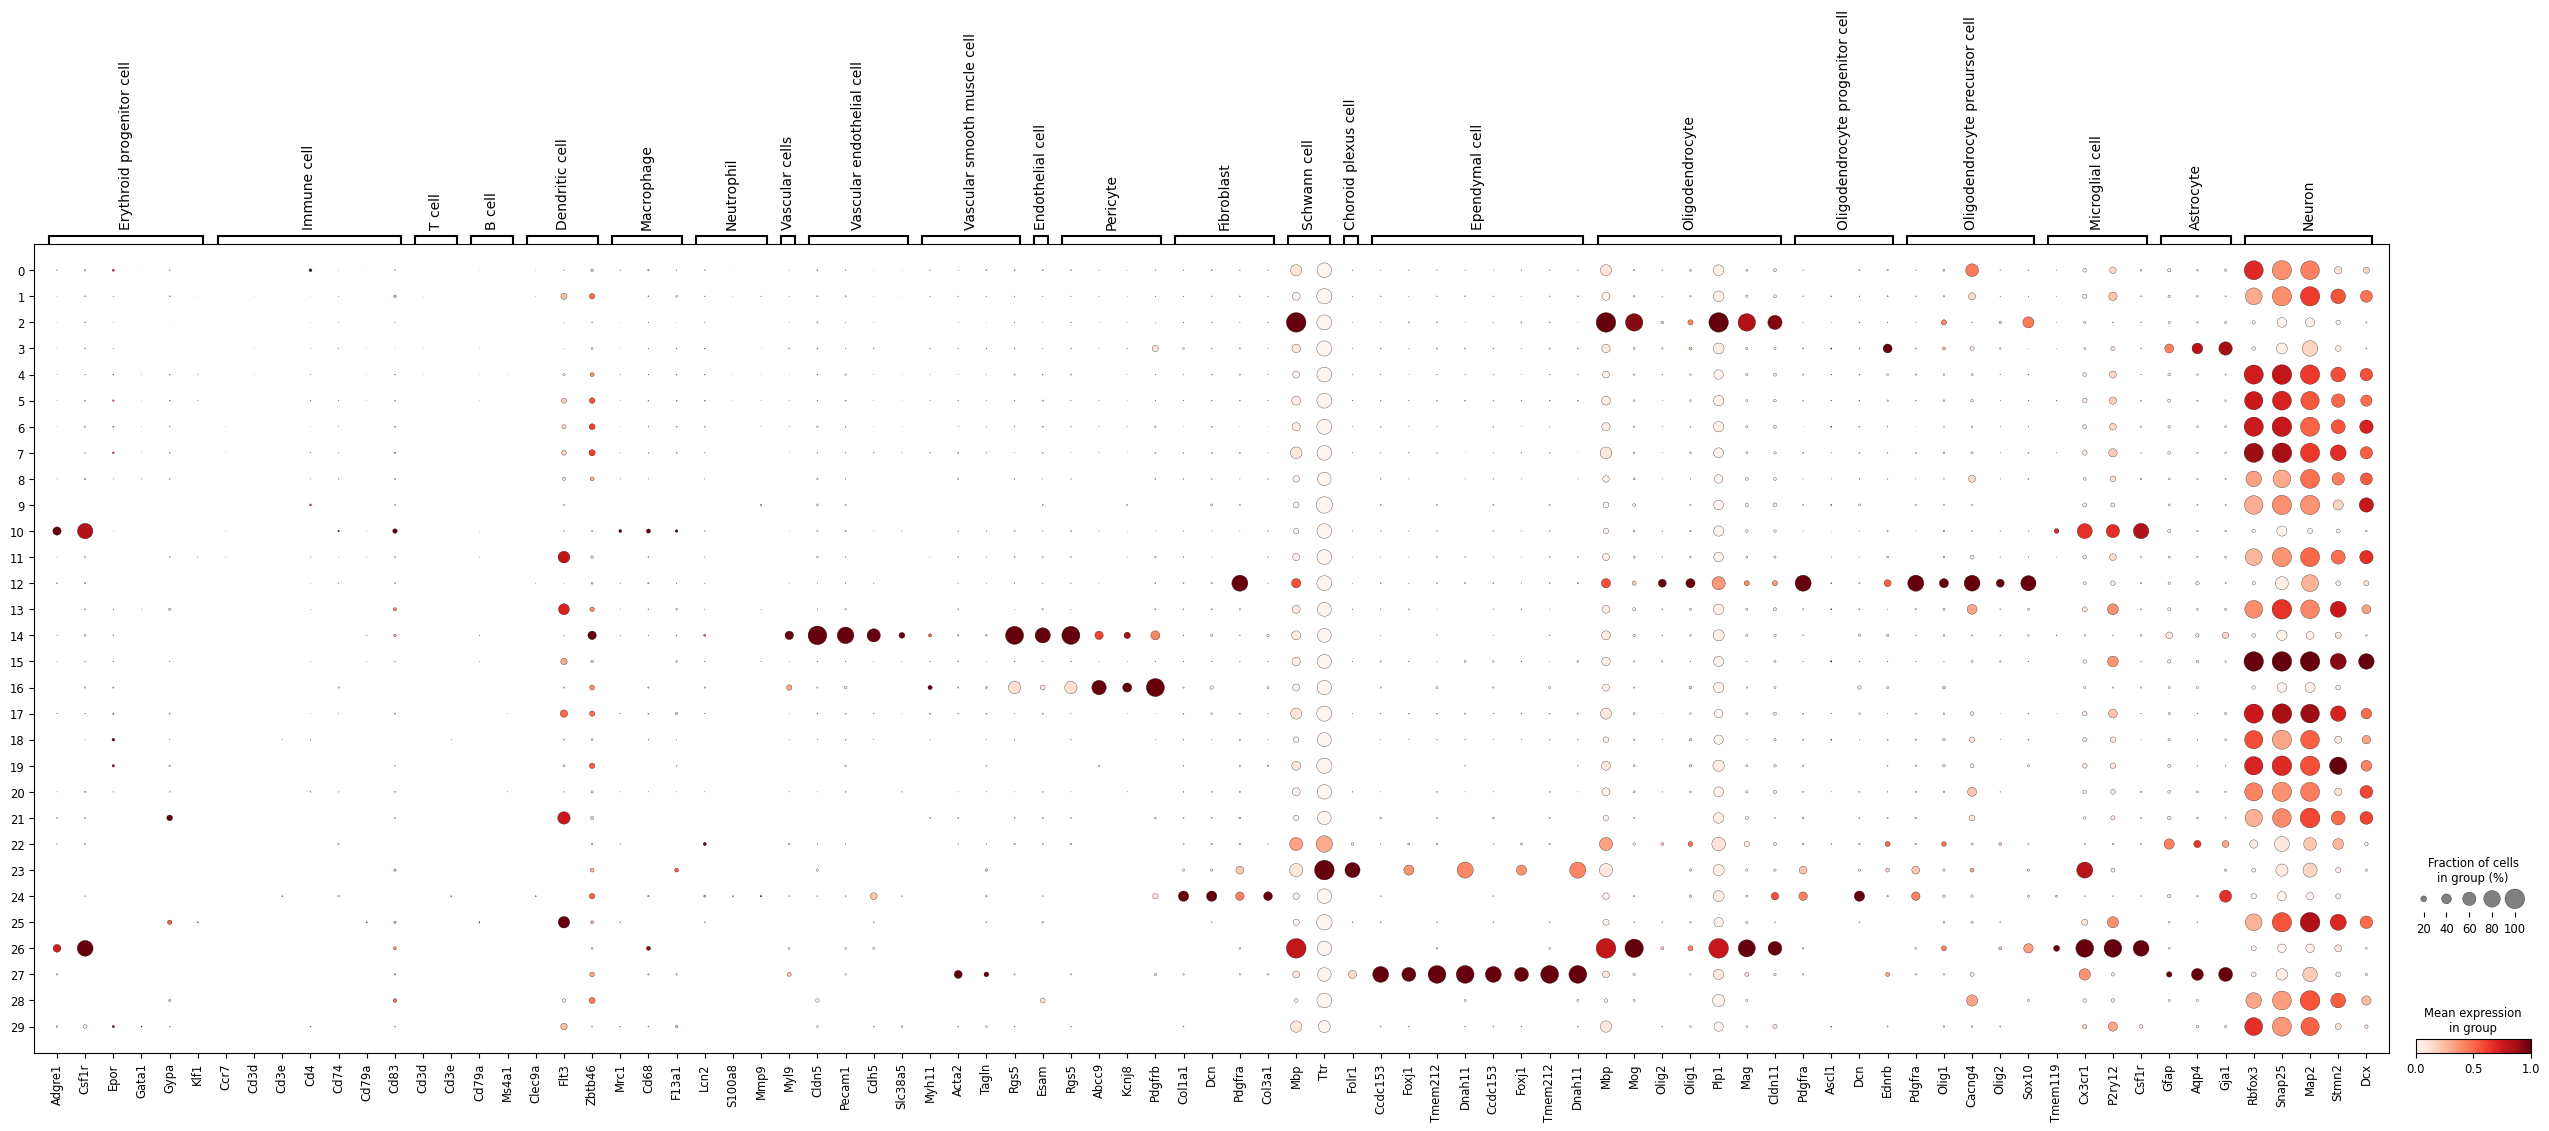

In [58]:
# 假设你的adata对象的obs中有一个名为'groupby'的列，其中包含了要分组的类别
dotplot = sc.pl.dotplot(
    adata,
    groupby="leiden_res1",
    var_names=smarker_genes_in_data,
    dendrogram=False,
    # cmap='RdBu_r',
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    return_fig=True
)
dotplot.savefig("figures/shame_anno_dotplot.pdf")

#### SCINA

In [59]:
import SCINApy as scina
scina.SCINA(adata=adata, signatures=small_marker_dict, inplace=True)
adata.obs = adata.obs.rename(columns={'scina_labels': 'scina_local_labels'})
adata.write(f"data/{config['project_code']}_annotated.h5ad")

/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/SCINApy/core.py:333: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(exponent_term, dtype=np.float64)
/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/SCINApy/core.py:333: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(exponent_term, dtype=np.float64)
/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/SCINApy/core.py:333: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(exponent_term, dtype=np.float64)
/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/SCINApy/core.py:333: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(exponent_term, dtype=np.float64)
/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/SCINApy/core.py:333: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(exponent_term, dtype=np.float64)
/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/SCINApy/core.py:333: RuntimeWarning: overflow encountered in exp
  tmp = np.exp(exponent_term

## 手动注释（基于聚类）

1. 优先认可自动注释结果，要求平均可能性超过50%
2. 其次选择手动注释结果，要求高表达量占比超过50%

In [60]:
%reset -f
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import os

os.getcwd()
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
sc.settings.verbosity = 3

adata = sc.read(f"data/{config['project_code']}_annotated.h5ad")
anno_res = adata.obs.loc[:, ['leiden_res1', 'auto_ref_celltype', 'auto_marker_celltype', 'scina_cellmarker_label', 'scina_local_labels']]

/opt/anaconda3/envs/bioinfo/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


在纹状体中，星形胶质细胞通过诱导神经干细胞相关基因（如 Ascl1）进入神经元谱系 ，然后是短暂的扩增阶段，然后产生**神经母细胞Neuroblasts簇**，最终产生神经元(Magnusson 等 人，2014 年)。中风后纹状体星形胶质细胞的神经发生是由 Notch 信号减少触发的，并且通过关键调节因子 Rbpj-κ 的条件缺失来阻断 Notch 活性足以激活这种神经源性程序，即使在没有损伤的情况下也是如此(Magnusson 等 人，2014).然而，驱动谱系命运转变的分子级联尚不清楚，并且仍有待确定实质星形胶质细胞产生成年出生神经元所需的转录程序是否与典型的神经源性过程相似。此外，当 Rbpj-κ 耗尽时，只有纹状体和内侧皮层中的星形胶质细胞会产生神经元，这引发了人们对它们在整个大脑中的神经源性潜力程度的质疑。
https://www.sciencedirect.com/science/article/pii/S1934590920303441

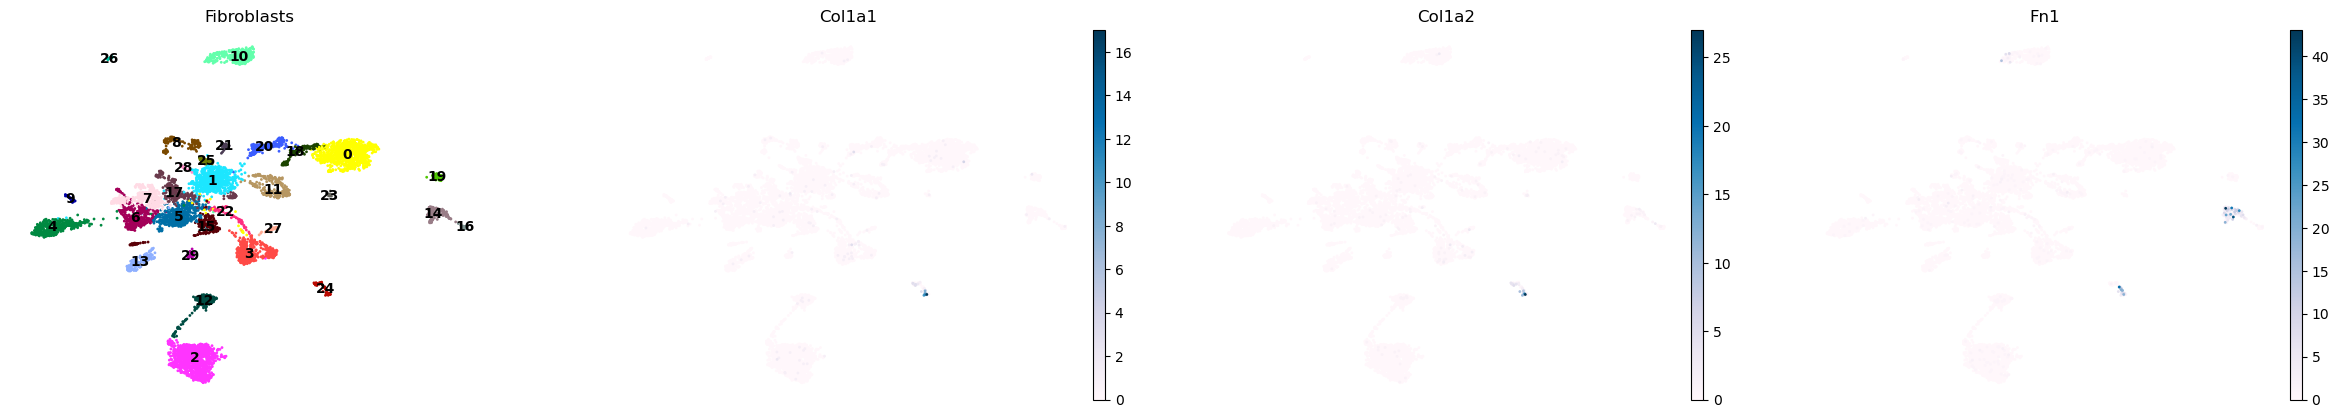

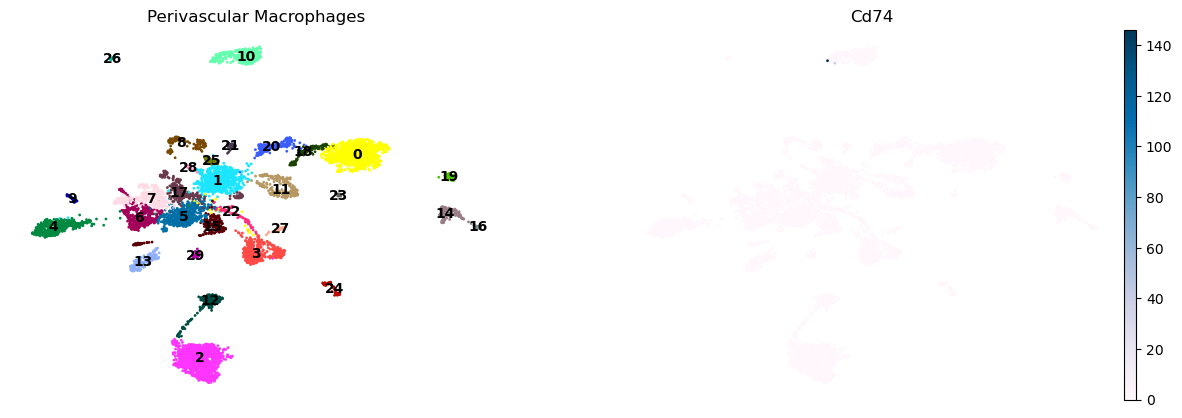

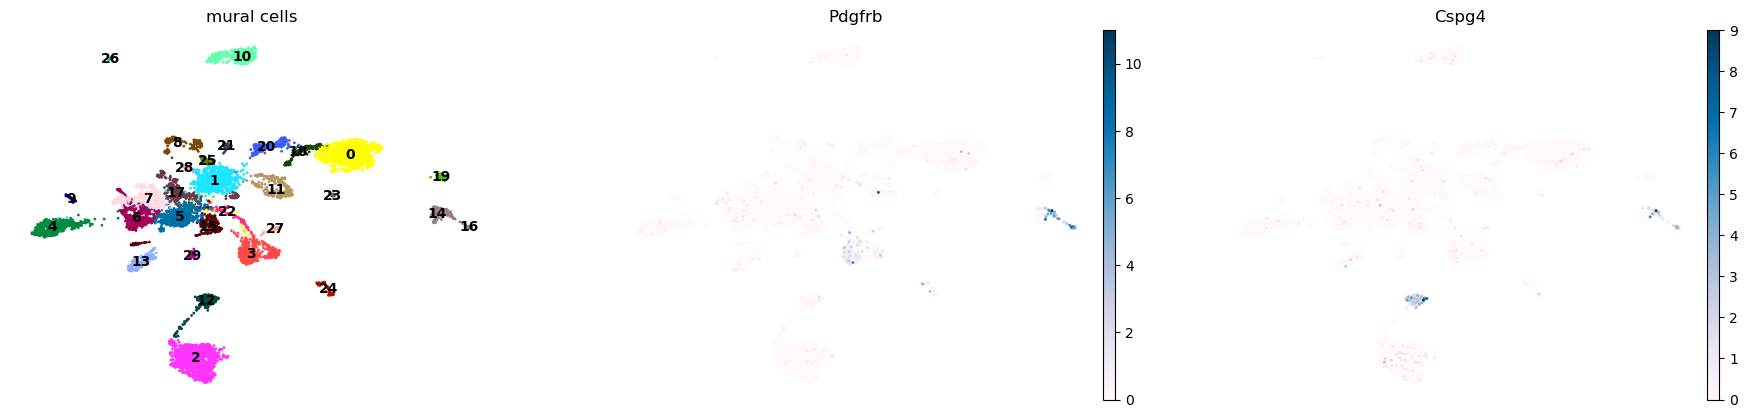

In [93]:
# 'Pecam1','Flt1','Pdgfrb',                # Endothelial/vascular

# 'Aqp4','Aldh1l1','Atp1b2','Slc1a3',      # ASTRO
# 'Gfap','Serpina3n',                      # Reactive ASTRO
# 'Cldn11','Mbp','Mobp',                   # OLIGO
# 'Pdgfra','Cspg4','Vcan',                 # OPC 
# 'Cx3cr1','Aif1',                         # MG
# 'Cd74',                                  # PVM PVM 通常指 Perivascular Macrophages（血管周巨噬细胞）
# # 神经元
# sc.pl.umap(adata, frameon=False, title="Neurons", legend_loc='on data', color=["leiden_res1", "Meg3","Rbfox3"], cmap='PuBu')
# # 谷氨酸能神经元
# # Slc17a6转录成VGLUT2蛋白(谷氨酸转运体2，Vesicular Glutamate Transporter 2), 主要在皮层下区域（如丘脑、脑干）和部分皮层神经元中高表达
# # Slc17a7是VGLUT1蛋白，主要在大脑皮层（如新皮层）和海马的兴奋性神经元中高表达
# # Satb2 是一种转录因子，结合富含AT的DNA序列，特别是在上层皮层神经元起关键作用
# sc.pl.umap(adata, frameon=False, title="Glutamatergic neurons", legend_loc='on data', color=["leiden_res1", "Slc17a6", 'Slc17a7', 'Satb2'], cmap='PuBu')
# # GABA能神经元
# sc.pl.umap(adata, frameon=False, title="GABAergic neurons", legend_loc='on data', color=["leiden_res1", 'Gad1', 'Gad2'], cmap='PuBu')

# # 星形胶质细胞
# sc.pl.umap(adata, frameon=False, title="Astrocytes", legend_loc='on data', color=["leiden_res1", 'Aqp4', 'Atp1b2', 'Gfap', 'S100b', 'Aldh1l1', 'Aldoc', 'Slc1a2', 'Slc1a3'], cmap='PuBu')
# # reactive 星形胶质细胞
# sc.pl.umap(adata, frameon=False, title="Reactive Astrocytes", legend_loc='on data', color=["leiden_res1", 'Gfap', 'Serpina3n'], cmap='PuBu')
# 成纤维细胞
sc.pl.umap(adata, frameon=False, title="Fibroblasts", legend_loc='on data', color=["leiden_res1", 'Col1a1', 'Col1a2', 'Fn1'], cmap='PuBu')
# # 少突胶质细胞
# sc.pl.umap(adata, frameon=False, title="Oligodendrocytes", legend_loc='on data', color=["leiden_res1", 'Mbp', 'Plp1', 'Cldn11', 'Mobp'], cmap='PuBu')

# # 免疫细胞
# sc.pl.umap(adata, frameon=False, title="Immune cells", legend_loc='on data', color=["leiden_res1", 'Inpp5d', 'Csf1r'], cmap='PuBu')
# # 小胶质细胞
# sc.pl.umap(adata, frameon=False, title="Microglia", legend_loc='on data', color=["leiden_res1", 'Cx3cr1', 'Aif1'], cmap='PuBu')
# Perivascular Macrophages（血管周巨噬细胞）
sc.pl.umap(adata, frameon=False, title="Perivascular Macrophages", legend_loc='on data', color=["leiden_res1", 'Cd74'], cmap='PuBu')

# # 干细胞和祖细胞 stem and progenitor cells Pdgfra是星胶干细胞和祖细胞
# sc.pl.umap(adata, frameon=False, title="stem and progenitor cells", legend_loc='on data', color=["leiden_res1", 'Sox10', 'Vcan', 'Pdgfra'], cmap='PuBu')
# # 少突胶质祖细胞 oligodendrocyte progenitor cells
# sc.pl.umap(adata, frameon=False, title="oligodendrocyte progenitor cells", legend_loc='on data', color=["leiden_res1", 'Pdgfra', 'Cspg4', 'Vcan'], cmap='PuBu')
# # 神经母细胞 Neuroblasts 某些成人脑区域（如海马齿状回和侧脑室下区）https://www.sciencedirect.com/science/article/pii/S1934590920303441
# sc.pl.umap(adata, frameon=False, title="Neuroblasts", legend_loc='on data', color=["leiden_res1", 'Dcx', 'Sp9', 'Ccnd2', 'Sox4', 'Stmn1'], cmap='PuBu')

# # Endothelial/vascular
# sc.pl.umap(adata, frameon=False, title="Endothelial/vascular", legend_loc='on data', color=["leiden_res1",'Pecam1','Flt1','Pdgfrb'], cmap='PuBu')
# # 血管细胞 Flt1就是VEGFR1
# sc.pl.umap(adata, frameon=False, title="vascular cells", legend_loc='on data', color=["leiden_res1", 'Flt1', 'Cldn5'], cmap='PuBu')
# 壁细胞 mural cells
sc.pl.umap(adata, frameon=False, title="mural cells", legend_loc='on data', color=["leiden_res1", 'Pdgfrb', 'Cspg4'], cmap='PuBu')
# # 室管膜细胞 Ependymal cells
# sc.pl.umap(adata, frameon=False, title="Ependymal cells", legend_loc='on data', color=["leiden_res1", 'Ccdc153','Foxj1'], cmap='PuBu')

# 'Ptgds','Mgp','Slc47a1',                 # VLMC

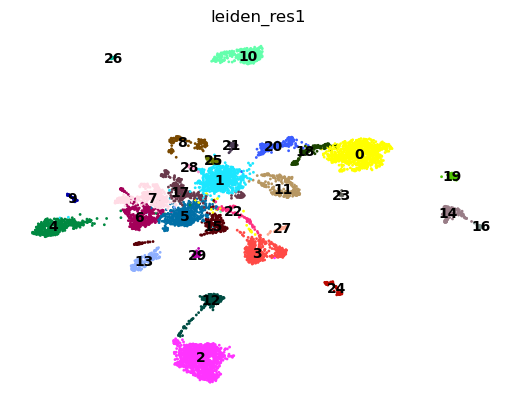

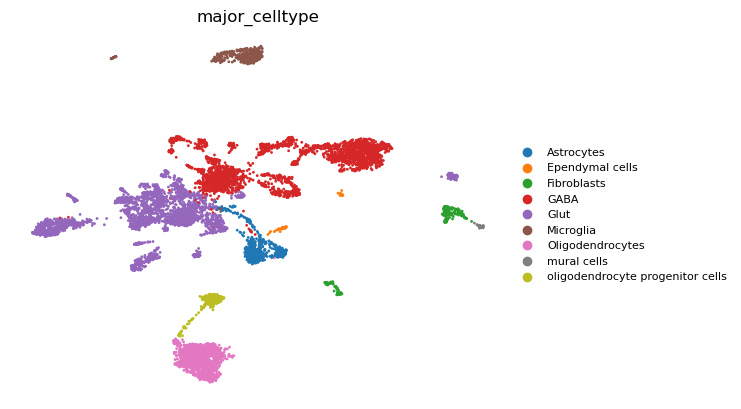

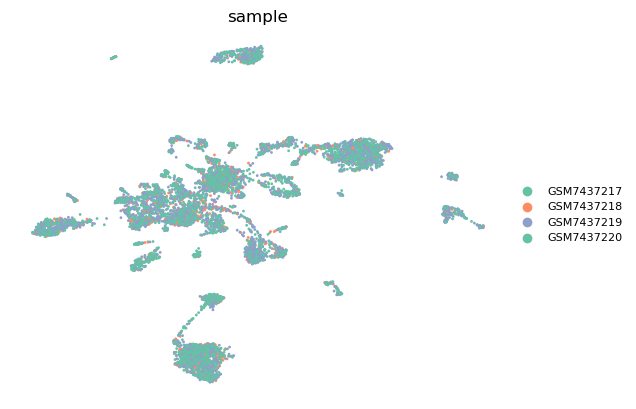

In [94]:
# '\d+':'(\w|\s)+',\s#(\w|\s)+
cluster2annotation = {
    '0':'GABA', # Neurons GABA
    '1':'GABA', # Neurons GABA
    '2':'Oligodendrocytes', # Oligodendrocytes Astrocytes
    '3':'Astrocytes', # Astrocytes
    '4':'Glut', # Neurons Glut
    '5':'Glut', # Neurons Glut
    '6':'Glut', # Neurons Glut
    '7':'Glut', # Neurons Glut
    '8':'GABA', # Neurons GABA
    '9':'Glut', # Neurons Glut
    '10':'Microglia', # Microglia
    '11':'GABA', # Neurons GABA
    '12':'oligodendrocyte progenitor cells', # Astrocytes oligodendrocyte progenitor cells
    '13':'Glut', # Neurons Glut
    '14':'Fibroblasts', # Fibroblasts mural cells
    '15':'Glut', # Neurons Glut
    '16':'mural cells', # mural cells
    '17':'Glut', # Neurons Glut
    '18':'GABA', # Neurons GABA
    '19':'Glut', # Neurons Glut
    '20':'GABA', # Neurons GABA
    '21':'GABA', # Neurons GABA
    '22':'Astrocytes', # Astrocytes
    '23':'Ependymal cells', # Ependymal cells
    '24':'Fibroblasts', # Fibroblasts
    '25':'GABA', # Neurons GABA
    '26':'Microglia', # Microglia
    '27':'Ependymal cells', # Ependymal cells
    '28':'GABA', # Neurons GABA
    '29':'Glut', # Neurons Glut
}
adata.obs['major_celltype'] = adata.obs['leiden_res1'].map(cluster2annotation).astype('category')
sc.pl.umap(adata, legend_loc="on data", frameon=False, color='leiden_res1')
sc.pl.umap(adata, frameon=False, color='major_celltype', legend_fontsize=8, save="_final_annotation_on_data.pdf")
sc.pl.umap(adata, frameon=False, color='sample', legend_fontsize=8,
    palette=['#66c2a5','#fc8d62','#8da0cb'], 
    save="_final_annotation_by_sample.pdf")

adata.write(f"data/{config['project_code']}_annotated.h5ad")

In [95]:
np.unique(adata.obs['major_celltype'])

array(['Astrocytes', 'Ependymal cells', 'Fibroblasts', 'GABA', 'Glut',
       'Microglia', 'Oligodendrocytes', 'mural cells',
       'oligodendrocyte progenitor cells'], dtype=object)